In [3]:
from pylab import *
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import numpy as np
import cv2
import warnings
import os
from random import randint
import itertools

warnings.simplefilter("ignore")

In [4]:
def readNames(path):
    fileList = os.listdir(path)
    return fileList

def readFile(path,filename,tif = False):
    
    if not(tif):
        base = cv2.imread(os.getcwd() + '/' + path + filename)
        base = cv2.cvtColor(base, cv2.COLOR_RGB2BGR)
    else:
        base = plt.imread(os.getcwd() + '/' + path + filename)
    return base
    

In [42]:
def divide(image, size = 5):
    dividedImages = []
    
    halfSize = int(size/2)
    
    print(halfSize)
    
    
    for i in range (halfSize, len(image) - halfSize):
        for j in range (halfSize, len(image[i]) - halfSize):
            dividedImage = image[i - halfSize:i + halfSize + 1,j - halfSize:j + halfSize + 1]
            
            dividedImages.append([[i - halfSize, j - halfSize], dividedImage])
    return dividedImages


In [6]:
def showImg(base, image):
    fig = figure(figsize=(20,10))
    subplot(1,2,1)
    imshow(base,cmap='gray')
    subplot(1,2,2)
    imshow(image,cmap='gray')

In [7]:
def checkValue(data, i, j):
    return data[i,j] != 0

In [50]:
def cutFromImage(image, x_size, y_size, divided_image_size):
    y_center = int(len(image[0])/2)
    
    imageToCheck = image[int(divided_image_size/2) : x_size + int(divided_image_size/2), y_center - int(y_size/2) : y_center + int(y_size/2)]
    
    imageToDivide = image[0: x_size + divided_image_size, y_center - int(y_size/2) - int(divided_image_size/2) : y_center + int(y_size/2) + int(divided_image_size/2)]
    
    dividedImages = divide(imageToDivide, divided_image_size)
    
    return imageToCheck, dividedImages
    

In [62]:
def prepareSmallImage(num, size):
    pathImages = 'HRF/images/'
    imagesFileList = readNames(pathImages)
    imagesFileList.sort()
    
    image = readFile(pathImages,imagesFileList[num])
    smallImage, dividedSmallImages = cutFromImage(image, 400,400, size)
    return smallImage, dividedSmallImages

In [ ]:
def compare(num):
    image, dividedImages = prepareSmallImage(num, 100)
#     doRedStaff on image
#     doSieć staff on each of dividedImages to get value for each and get l

50


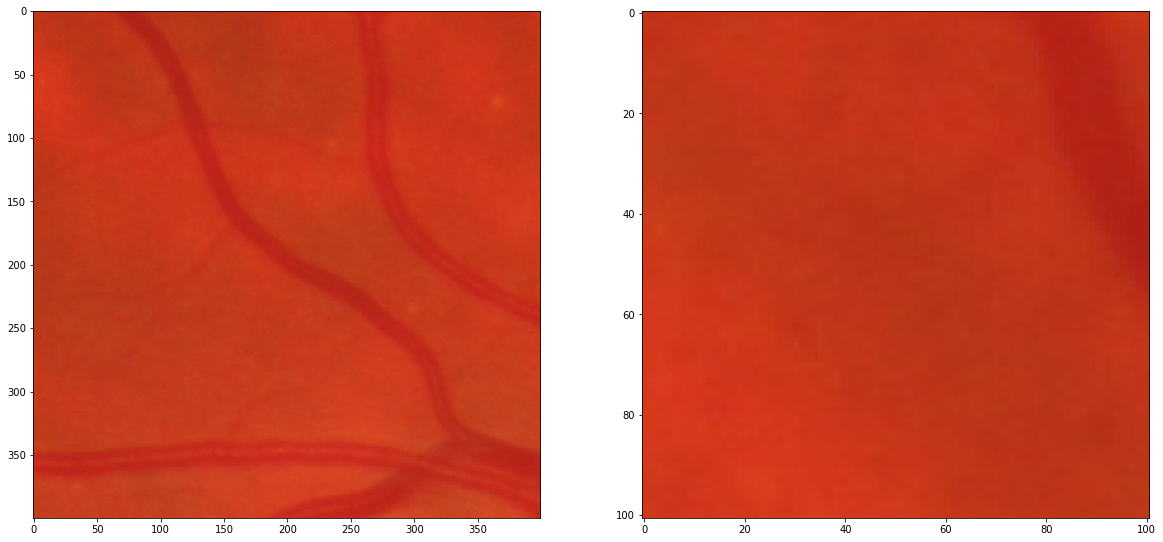

In [9]:

def meanError(image, dataFile):
    if image.shape != dataFile.shape:
        return 0
    
    error = 0.0
    for i in range(len(image)):
        for j in range(len(image[i])):
            error = error + (image[i,j]-dataFile[i,j])**2
            
    error = error / (dataFile.shape[0]*dataFile.shape[1])
    
    return error

def addVeinToImage(image, foundVeinImage):
    outputImage = image.copy()
    for i in range(len(image)):
        for j in range(len(image[i])):
            if foundVeinImage[i,j] == 255:
                outputImage[i,j] = [255,255,255]
                
    return outputImage

def takeRandomSmallImages(imageDataMask, size = 5, amount = 200):
    trueImages = []
    falseImages = []
    halfSize = int(size/2)
    while(len(trueImages) < amount or len(falseImages) < amount):
        x = randint(0, len(imageDataMask[0]) - 1)
        y = randint(0, len(imageDataMask[0][x]) - 1)
        if(np.all(imageDataMask[2][x, y] == 255)):
            if(imageDataMask[1][x, y] == 0):
                if(len(falseImages) < amount):
                    falseImages.append(imageDataMask[0][x - halfSize:x + halfSize + 1,y - halfSize:y + halfSize + 1])
            else:
                if(len(trueImages) < amount):
                    trueImages.append(imageDataMask[0][x - halfSize:x + halfSize + 1,y - halfSize:y + halfSize + 1])
    return trueImages, falseImages

[[200  55  26]
 [199  54  25]
 [199  56  26]
 ...
 [192  51  23]
 [191  52  23]
 [192  53  24]]


TypeError: Invalid dimensions for image data

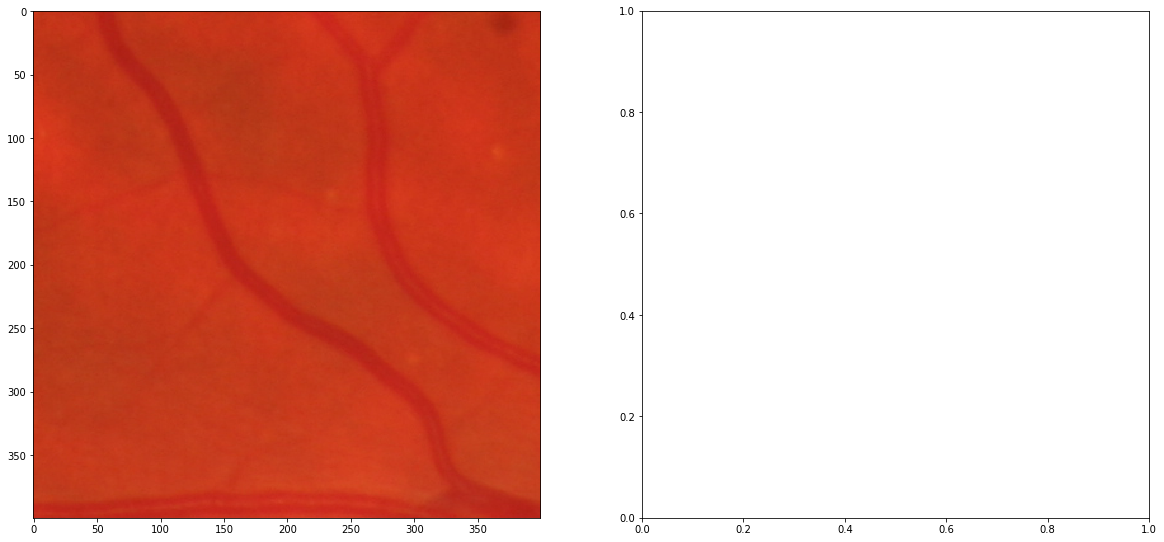

In [13]:
def prepareData(idList, size):
    pathImages = 'HRF/images/'
    pathData = 'HRF/manual1/'
    pathMask = 'HRF/mask/'
    imagesFileList = readNames(pathImages)
    dataFileList = readNames(pathData)
    maskFileList = readNames(pathMask)

    imagesFileList.sort()
    dataFileList.sort()
    maskFileList.sort()

    trueImagesList = []
    falseImagesList = []
    
    for imageId in idList:
        imageDataMask = getImageDataMask(imageId, [pathImages,pathData,pathMask], [imagesFileList,dataFileList,maskFileList])

        trueImages, falseImages = takeRandomSmallImages(imageDataMask, size)
        if(len(trueImagesList) == 0):
            trueImagesList = trueImages
            falseImagesList = falseImages
        else:
            trueImagesList = trueImagesList + trueImages
            falseImagesList = falseImagesList + falseImages
        
    return trueImagesList, falseImagesList

In [14]:
def prepareTrainData(size):
    trueData, falseData = prepareData([1,2,3,4], size)
    trueImgLen = len(trueData)
    falseImgLen = len(falseData)
    size = trueImgLen + falseImgLen

    #przypisanie etykiet 1-żyła, 0-inne
    labels = np.ones((size,), dtype=int)
    labels[0:trueImgLen] = 1
    labels[trueImgLen:] = 0
        
    images = trueData + falseData

    #konwersja do sklai szarości i ujednolicenie wymiarow
    grayImages = toGrayScaleAndResize(images, size, size)
        
    imgMatrix = np.array([np.array(img).flatten() for img in grayImages])

    #losowe rozmieszczenie obrazow w w zbiorze treningowym
    data, Label = shuffle(imgMatrix, labels, random_state=2)
    train_data = [data,Label]
    
    return train_data

In [15]:
def getImageDataMask(num, paths, fileLists):
    image = readFile(paths[0],fileLists[0][num])
    data = readFile(paths[1],fileLists[1][num], True)
    mask = readFile(paths[2], fileLists[2][num], True)
    
    return [image,data,mask]

In [16]:
def toGrayScaleAndResize(images, x, y):
    img = []
    for i in images:
        gray = cv2.cvtColor(i, cv2.COLOR_RGB2GRAY)
        img.append(cv2.resize(gray, (x, y)))
        
    return img

In [13]:
x = prepareTrainData(20)


NameError: name 'getImageDataMask' is not defined

In [41]:
from __future__ import print_function
import numpy as np

def valid_imshow_data(data):
    data = np.asarray(data)
    if data.ndim == 2:
        return True
    elif data.ndim == 3:
        if 3 <= data.shape[2] <= 4:
            return True
        else:
            print('The "data" has 3 dimensions but the last dimension '
                  'must have a length of 3 (RGB) or 4 (RGBA), not "{}".'
                  ''.format(data.shape[2]))
            return False
    else:
        print('To visualize an image the data must be 2 dimensional or '
              '3 dimensional, not "{}".'
              ''.format(data.ndim))
        return False

In [10]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils


import theano
np.random.seed(7)

from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


Using TensorFlow backend.
/home/mateusz/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [11]:
def cnn(no, epoch=20):

    #wczytanie sciezek i nazw plikow
    pathImages = 'HRF/images/'
    pathData = 'HRF/manual1/'
    pathMask = 'HRF/mask/'
    imagesFileList = readNames(pathImages)
    dataFileList = readNames(pathData)
    maskFileList = readNames(pathMask)

    imagesFileList.sort()
    dataFileList.sort()
    maskFileList.sort()

    #wczytanie plikow
    image = readFile(pathImages,imagesFileList[no])
    data = readFile(pathData,dataFileList[no], tif=True)
    mask = readFile(pathMask,maskFileList[no], tif=True)

    #print(mask.shape, image.shape, data.shape)

    #podzial obrazow na part**2 czesci
    dividedImages = divide1(image, mask, part=20)
    dividedData = divide1(data, mask, part=20)

    img_rows = dividedImages[0].shape[0]
    img_columns = dividedImages[0].shape[1]


    #print(len(dividedImages))
    #print(len(dividedData))

    showImg(dividedImages[0],dividedImages[-1])


    valuedImages = assignValue1(dividedImages, dividedData)

    veinImgLen = len(valuedImages[0])
    otherImgLen = len(valuedImages[1])
    size = veinImgLen + otherImgLen

    #print(size)

    #przypisanie etykiet 1-żyła, 0-inne
    labels = np.ones((size,), dtype=int)
    labels[0:veinImgLen] = 1
    labels[veinImgLen:] = 0

    images = valuedImages[0] + valuedImages[1]

    #konwersja do sklai szarości i ujednolicenie wymiarow
    grayImages = toGrayScaleAndResize(images, img_columns, img_rows)
    #print(len(grayImages))

    showImg(images[0], grayImages[0])


    #przygotowanie macierzy wektorów gdzie kazdy wiersz to wektor obrazu; flatten - spłaszczenie macierzy
    imgMatrix = np.array([np.array(img).flatten() for img in grayImages])
    #print(imgMatrix)

    #losowe rozmieszczenie obrazow w w zbiorze treningowym
    data, Label = shuffle(imgMatrix, labels, random_state=2)
    train_data = [data,Label]

    #print(train_data[0].shape, train_data[1].shape)

    img=imgMatrix[12].reshape(img_rows, img_columns)

    (X, y) = (train_data[0],train_data[1])

    #zbiory treningowe i testowe

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)


    X_train = X_train.reshape(X_train.shape[0], img_rows, img_columns, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_columns, 1)

    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

    X_train /= 255
    X_test /= 255

    #print('X_train shape:', X_train.shape)
    #print(X_train.shape[0], 'train samples')
    #print(X_test.shape[0], 'test samples')

    batch_size = 32
    nb_classes = 2
    nb_epoch = epoch
    nb_filters = 32
    nb_pool = 2
    nb_conv = 3

    Y_train = np_utils.to_categorical(y_train, nb_classes)
    Y_test = np_utils.to_categorical(y_test, nb_classes)

    #budowa modelu sieci neuronowej

    model = Sequential()

    model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
                            border_mode='valid',
                            input_shape=(img_rows, img_columns, 1)))
    convout1 = Activation('relu')
    model.add(convout1)
    model.add(Convolution2D(nb_filters, nb_conv, nb_conv))
    convout2 = Activation('relu')
    model.add(convout2)
    model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

    #trenowanie modelu


    #hist = model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
    #              verbose=1, validation_data=(X_test, Y_test))


    hist = model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
                  verbose=1, validation_split=0.2)


    score = model.evaluate(X_test, Y_test, verbose=0)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])
    #print(model.predict_classes(X_test[1:3]))
    #print(Y_test[1:3])


    Y_pred = model.predict(X_test)
    #print(Y_pred)
    y_pred = np.argmax(Y_pred, axis=1)
    #print(y_pred)

    cm = confusion_matrix(np.argmax(Y_test,axis=1), y_pred)
    print(confusion_matrix(np.argmax(Y_test,axis=1), y_pred))

    # Plot normalized confusion matrix
    class_names = ['vein', 'other']

    plt.figure()
    plot_confusion_matrix(cm, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()


    #fname = "weights-Test-CNN2.hdf5"
    #model.save_weights(fname,overwrite=True)

In [12]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')




In [64]:
def resize(img, size=30):     
    return np.resize(img,(size, size))


# liczba zdjec skladowych = part**2
def divide1(image, mask, part=10):
    dividedImages=[]
    
    rows = np.linspace(0, image.shape[0], part+1, dtype=int)
    columns = np.linspace(0, image.shape[1], part+1, dtype=int)
    
    for i in range(1, len(rows)):
        for j in range(1, len(columns)):
            m = mask[rows[i-1]:rows[i], columns[j-1]:columns[j]]
            row_centre = int((rows[i]-rows[i-1])/2)
            column_centre = int((columns[j]-columns[j-1])/2)
            #print(m[row_centre,column_centre], row_centre, column_centre)
            
            
            if (m[row_centre,column_centre,1] != 0):
                dividedImages.append(image[rows[i-1]:rows[i], columns[j-1]:columns[j]])
    return dividedImages

def checkVein(data):
    
    x = data.shape[0]
    y = data.shape[1]
    
    centre_x = int(x/2)
    centre_y = int(y/2)
    
    return data[centre_x, centre_y] != 0


def assignValue1(dividedImages, dividedData):
    trueImages = []
    falseImages = []
    for i in range(0,len(dividedImages)):
        if checkVein(dividedData[i]):
            trueImages.append(dividedImages[i])
        else:
            falseImages.append(dividedImages[i])
            
    return [trueImages, falseImages]




Train on 214 samples, validate on 54 samples
Epoch 1/20
214/214 [==============================] - 23s 109ms/step - loss: 1.2256 - acc: 0.8925 - val_loss: 1.7909 - val_acc: 0.8889
Epoch 2/20
214/214 [==============================] - 18s 84ms/step - loss: 1.2804 - acc: 0.9206 - val_loss: 1.7909 - val_acc: 0.8889
Epoch 3/20
214/214 [==============================] - 19s 87ms/step - loss: 1.2804 - acc: 0.9206 - val_loss: 1.7909 - val_acc: 0.8889
Epoch 4/20
214/214 [==============================] - 19s 90ms/step - loss: 1.2804 - acc: 0.9206 - val_loss: 1.7909 - val_acc: 0.8889
Epoch 5/20
214/214 [==============================] - 19s 90ms/step - loss: 1.2804 - acc: 0.9206 - val_loss: 1.7909 - val_acc: 0.8889
Epoch 6/20
214/214 [==============================] - 19s 87ms/step - loss: 1.2804 - acc: 0.9206 - val_loss: 1.7909 - val_acc: 0.8889
Epoch 7/20
214/214 [==============================] - 18s 86ms/step - loss: 1.2804 - acc: 0.9206 - val_loss: 1.7909 - val_acc: 0.8889
Epoch 8/20
214/2

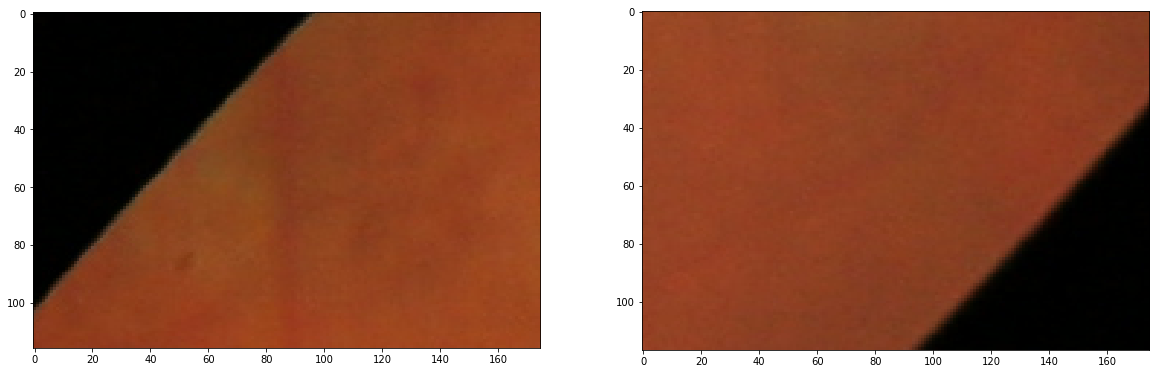

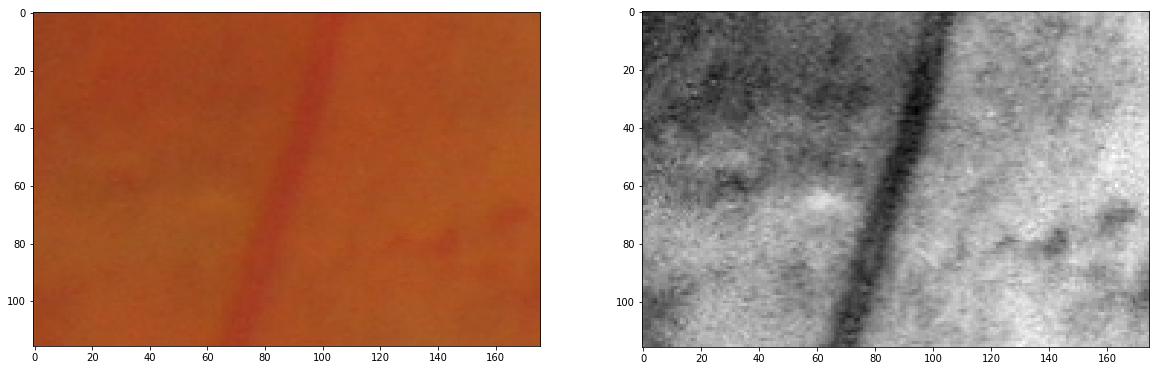

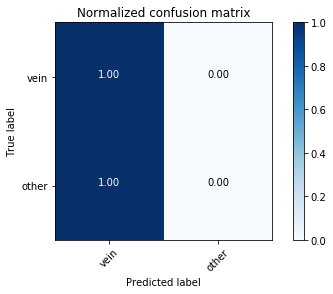

In [13]:
cnn(39)

Train on 215 samples, validate on 54 samples
Epoch 1/10
215/215 [==============================] - 40s 186ms/step - loss: 0.4855 - acc: 0.8698 - val_loss: 1.4924 - val_acc: 0.9074
Epoch 2/10
215/215 [==============================] - 18s 83ms/step - loss: 0.5248 - acc: 0.9674 - val_loss: 1.4924 - val_acc: 0.9074
Epoch 3/10
215/215 [==============================] - 17s 81ms/step - loss: 0.5248 - acc: 0.9674 - val_loss: 1.4924 - val_acc: 0.9074
Epoch 4/10
215/215 [==============================] - 18s 82ms/step - loss: 0.5248 - acc: 0.9674 - val_loss: 1.4924 - val_acc: 0.9074
Epoch 5/10
215/215 [==============================] - 18s 82ms/step - loss: 0.5248 - acc: 0.9674 - val_loss: 1.4924 - val_acc: 0.9074
Epoch 6/10
215/215 [==============================] - 17s 81ms/step - loss: 0.5248 - acc: 0.9674 - val_loss: 1.4924 - val_acc: 0.9074
Epoch 7/10
215/215 [==============================] - 18s 83ms/step - loss: 0.5248 - acc: 0.9674 - val_loss: 1.4924 - val_acc: 0.9074
Epoch 8/10
215/2

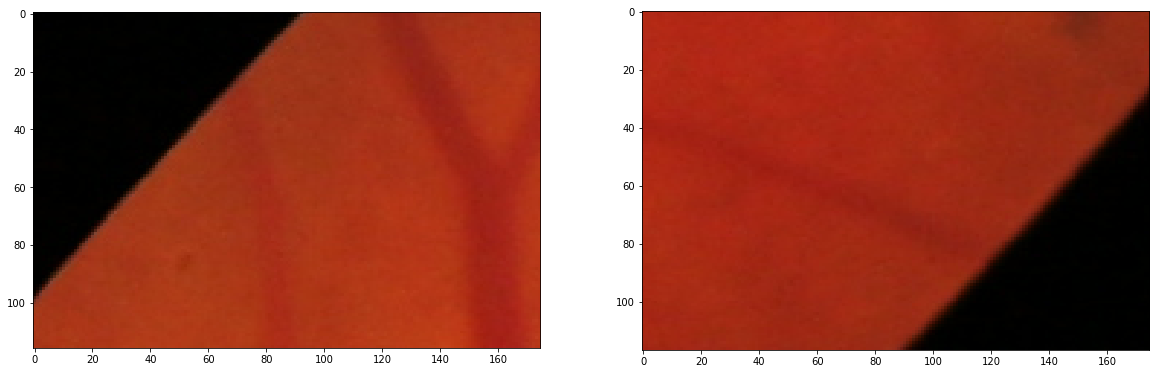

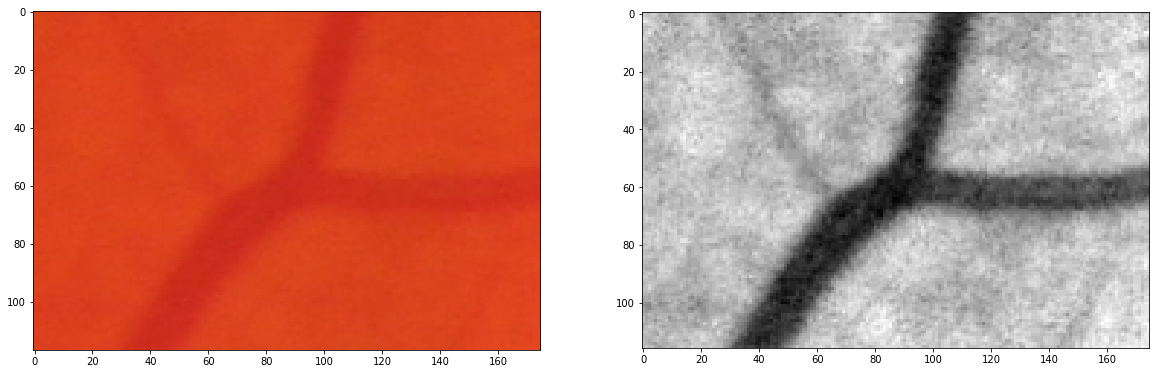

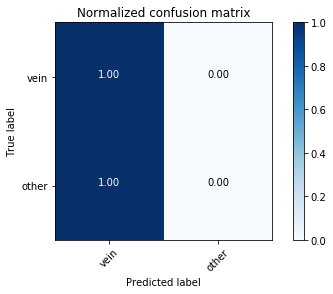

In [15]:
cnn(0,10)

Train on 215 samples, validate on 54 samples
Epoch 1/10
215/215 [==============================] - 42s 195ms/step - loss: 1.0636 - acc: 0.9116 - val_loss: 1.4924 - val_acc: 0.9074
Epoch 2/10
215/215 [==============================] - 18s 82ms/step - loss: 1.0496 - acc: 0.9349 - val_loss: 1.4924 - val_acc: 0.9074
Epoch 3/10
215/215 [==============================] - 17s 81ms/step - loss: 1.0496 - acc: 0.9349 - val_loss: 1.4924 - val_acc: 0.9074
Epoch 4/10
215/215 [==============================] - 18s 85ms/step - loss: 1.0496 - acc: 0.9349 - val_loss: 1.4924 - val_acc: 0.9074
Epoch 5/10
215/215 [==============================] - 18s 82ms/step - loss: 1.0496 - acc: 0.9349 - val_loss: 1.4924 - val_acc: 0.9074
Epoch 6/10
215/215 [==============================] - 18s 83ms/step - loss: 1.0496 - acc: 0.9349 - val_loss: 1.4924 - val_acc: 0.9074
Epoch 7/10
215/215 [==============================] - 18s 82ms/step - loss: 1.0496 - acc: 0.9349 - val_loss: 1.4924 - val_acc: 0.9074
Epoch 8/10
215/2

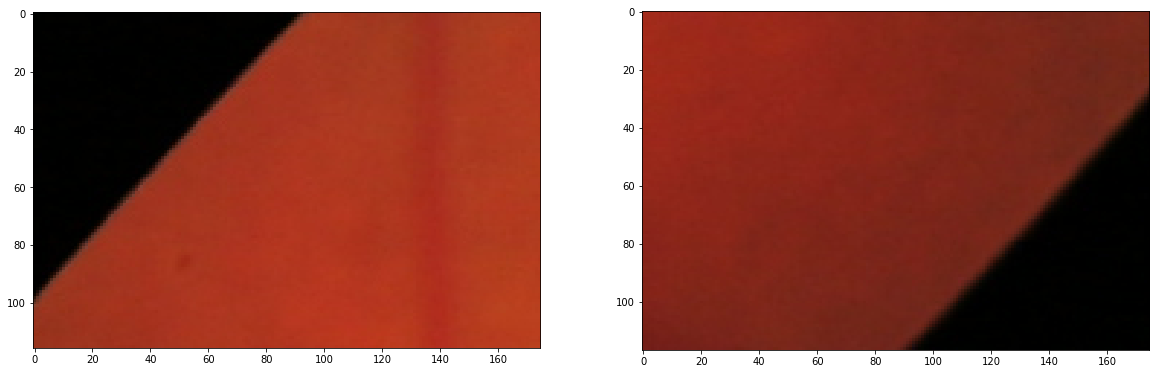

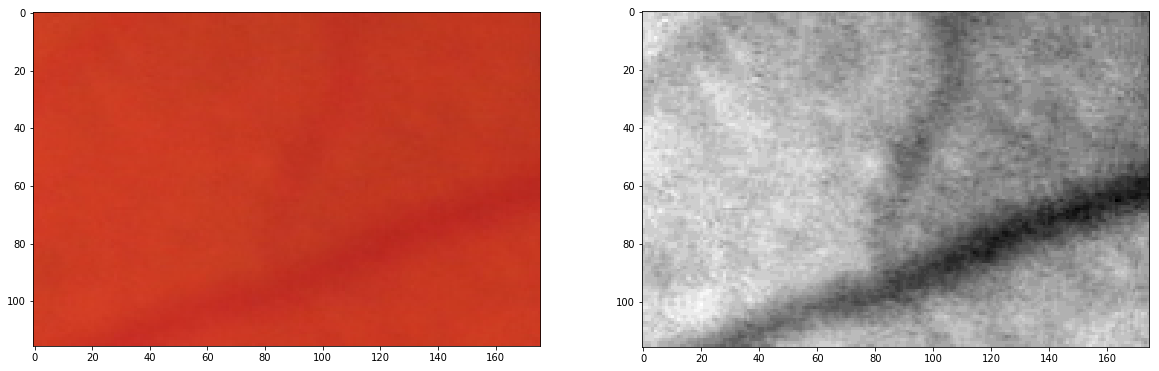

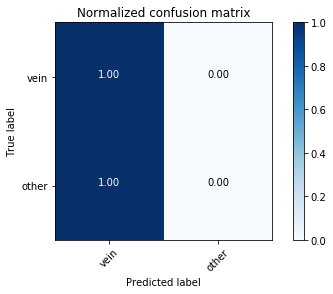

In [16]:
cnn(10,10)

Train on 214 samples, validate on 54 samples
Epoch 1/10
214/214 [==============================] - 45s 211ms/step - loss: 1.1657 - acc: 0.8318 - val_loss: 0.5058 - val_acc: 0.9074
Epoch 2/10
214/214 [==============================] - 19s 87ms/step - loss: 0.4193 - acc: 0.9019 - val_loss: 0.3189 - val_acc: 0.9074
Epoch 3/10
214/214 [==============================] - 18s 86ms/step - loss: 0.3792 - acc: 0.9019 - val_loss: 0.3178 - val_acc: 0.9074
Epoch 4/10
214/214 [==============================] - 18s 84ms/step - loss: 0.3746 - acc: 0.9019 - val_loss: 0.3159 - val_acc: 0.9074
Epoch 5/10
214/214 [==============================] - 18s 84ms/step - loss: 0.3883 - acc: 0.9019 - val_loss: 0.3394 - val_acc: 0.9074
Epoch 6/10
214/214 [==============================] - 18s 84ms/step - loss: 0.3881 - acc: 0.9019 - val_loss: 0.3491 - val_acc: 0.9074
Epoch 7/10
214/214 [==============================] - 18s 84ms/step - loss: 0.3812 - acc: 0.9019 - val_loss: 0.3270 - val_acc: 0.9074
Epoch 8/10
214/2

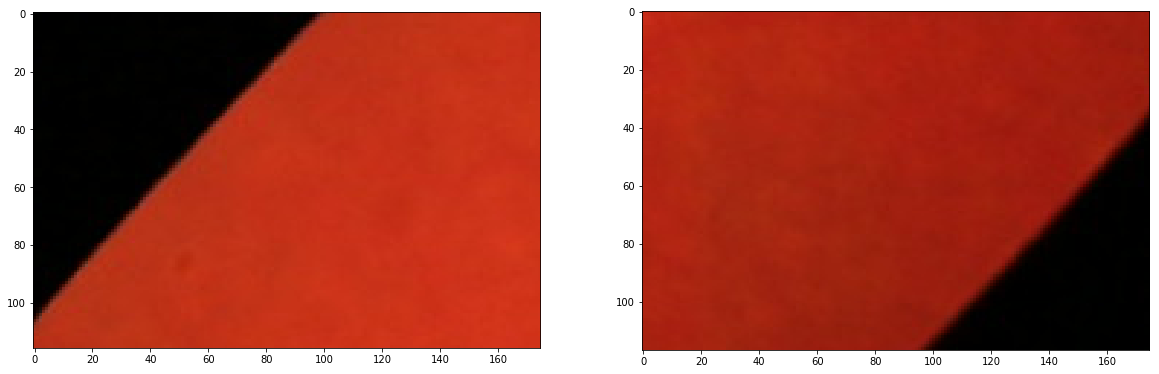

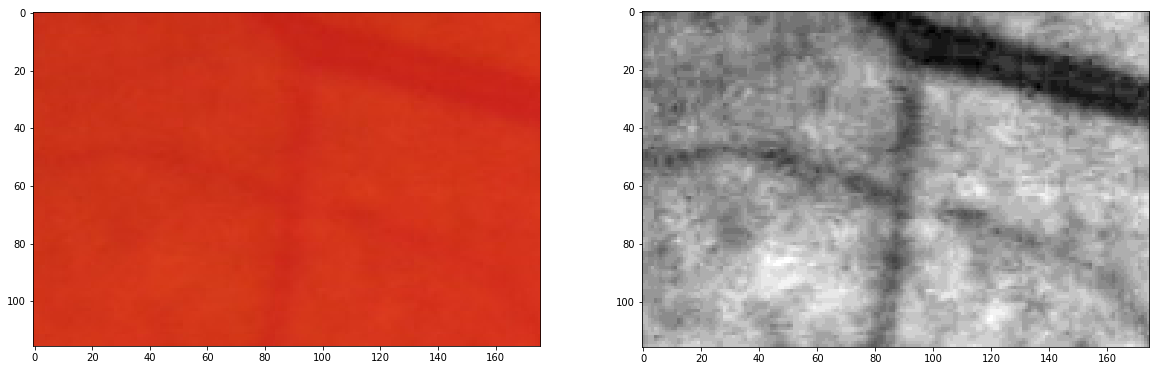

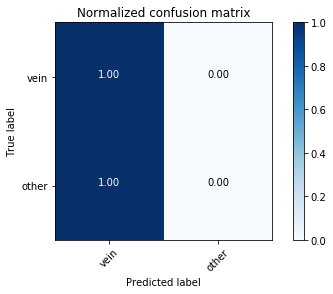

In [17]:
cnn(20,10)

Train on 215 samples, validate on 54 samples
Epoch 1/10
215/215 [==============================] - 61s 283ms/step - loss: 0.8501 - acc: 0.8093 - val_loss: 0.6795 - val_acc: 0.8519
Epoch 2/10
215/215 [==============================] - 22s 101ms/step - loss: 0.3463 - acc: 0.9209 - val_loss: 0.5890 - val_acc: 0.8519
Epoch 3/10
215/215 [==============================] - 20s 95ms/step - loss: 0.3179 - acc: 0.9209 - val_loss: 0.4346 - val_acc: 0.8519
Epoch 4/10
215/215 [==============================] - 20s 94ms/step - loss: 0.3019 - acc: 0.9209 - val_loss: 0.4794 - val_acc: 0.8519
Epoch 5/10
215/215 [==============================] - 18s 84ms/step - loss: 0.3319 - acc: 0.9209 - val_loss: 0.4275 - val_acc: 0.8519
Epoch 6/10
215/215 [==============================] - 18s 83ms/step - loss: 0.3144 - acc: 0.9209 - val_loss: 0.4240 - val_acc: 0.8519
Epoch 7/10
215/215 [==============================] - 19s 87ms/step - loss: 0.3360 - acc: 0.9209 - val_loss: 0.4266 - val_acc: 0.8519
Epoch 8/10
215/

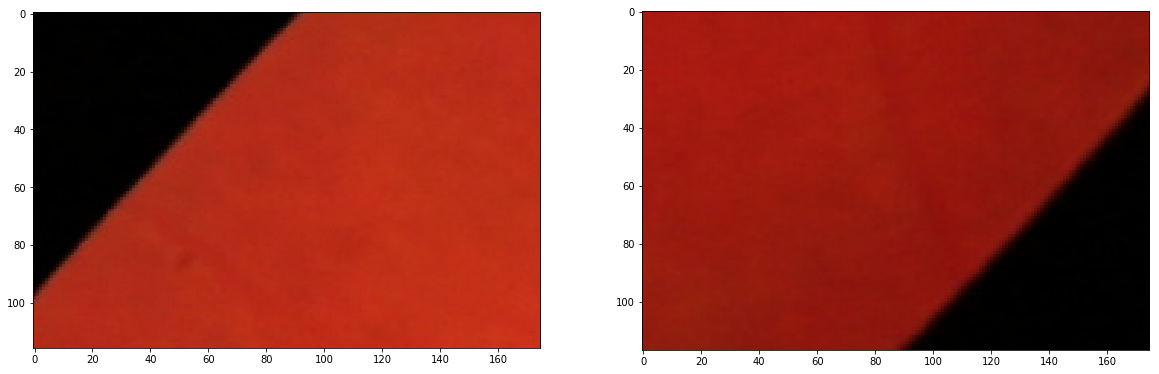

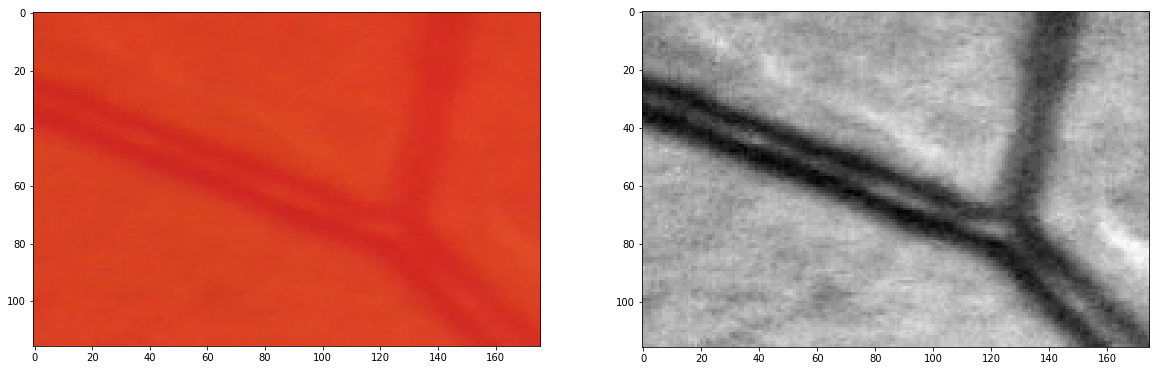

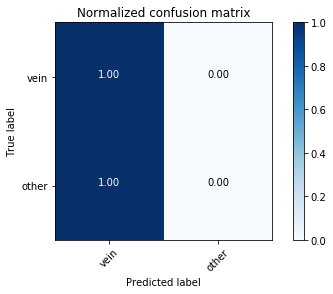

In [18]:
cnn(30,10)

Train on 215 samples, validate on 54 samples
Epoch 1/20
215/215 [==============================] - 45s 208ms/step - loss: 1.1517 - acc: 0.8744 - val_loss: 2.3879 - val_acc: 0.8519
Epoch 2/20
215/215 [==============================] - 23s 106ms/step - loss: 1.2745 - acc: 0.9209 - val_loss: 2.3879 - val_acc: 0.8519
Epoch 3/20
215/215 [==============================] - 20s 92ms/step - loss: 1.2745 - acc: 0.9209 - val_loss: 2.3879 - val_acc: 0.8519
Epoch 4/20
215/215 [==============================] - 21s 96ms/step - loss: 1.2745 - acc: 0.9209 - val_loss: 2.3879 - val_acc: 0.8519
Epoch 5/20
215/215 [==============================] - 21s 98ms/step - loss: 1.2745 - acc: 0.9209 - val_loss: 2.3879 - val_acc: 0.8519
Epoch 6/20
215/215 [==============================] - 19s 90ms/step - loss: 1.2745 - acc: 0.9209 - val_loss: 2.3879 - val_acc: 0.8519
Epoch 7/20
215/215 [==============================] - 23s 105ms/step - loss: 1.2745 - acc: 0.9209 - val_loss: 2.3879 - val_acc: 0.8519
Epoch 8/20
215

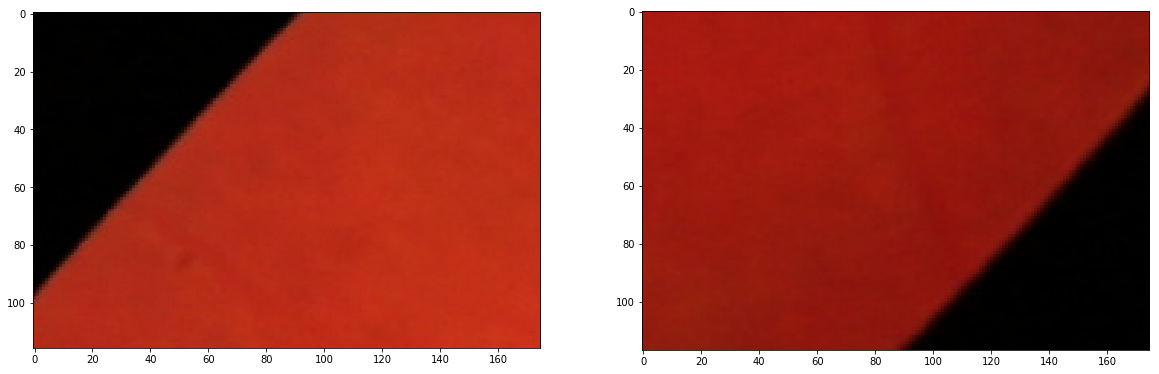

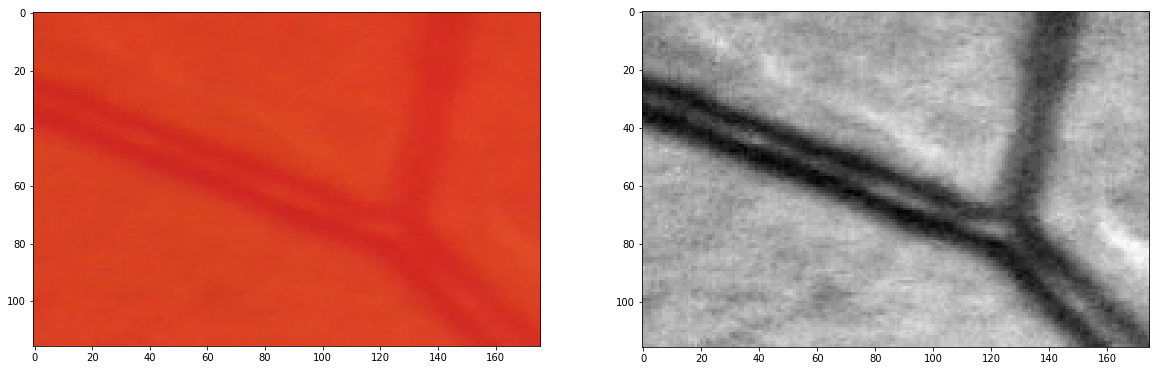

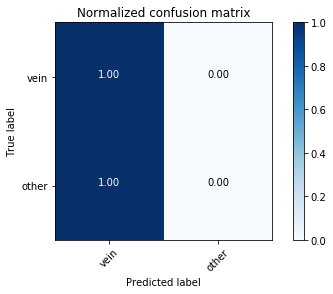

In [19]:
cnn(30,20)

Train on 1937 samples, validate on 485 samples
Epoch 1/10
1937/1937 [==============================] - 159s 82ms/step - loss: 0.6582 - acc: 0.8942 - val_loss: 0.3495 - val_acc: 0.9196
Epoch 2/10
1937/1937 [==============================] - 157s 81ms/step - loss: 0.3765 - acc: 0.8962 - val_loss: 0.2935 - val_acc: 0.9196
Epoch 3/10
1937/1937 [==============================] - 155s 80ms/step - loss: 0.3676 - acc: 0.8962 - val_loss: 0.3218 - val_acc: 0.9196
Epoch 4/10
1937/1937 [==============================] - 157s 81ms/step - loss: 0.3577 - acc: 0.8962 - val_loss: 0.3077 - val_acc: 0.9196
Epoch 5/10
1937/1937 [==============================] - 165s 85ms/step - loss: 0.3511 - acc: 0.8962 - val_loss: 0.3129 - val_acc: 0.9196
Epoch 6/10
1937/1937 [==============================] - 177s 91ms/step - loss: 0.3590 - acc: 0.8962 - val_loss: 0.3441 - val_acc: 0.9196
Epoch 7/10
1937/1937 [==============================] - 173s 89ms/step - loss: 0.3507 - acc: 0.8962 - val_loss: 0.2923 - val_acc: 0

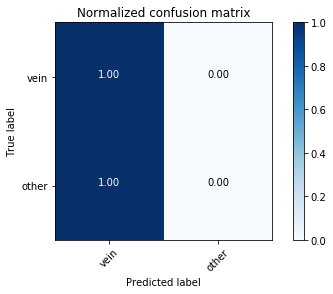

In [21]:
    #wczytanie sciezek i nazw plikow
    pathImages = 'HRF/images/'
    pathData = 'HRF/manual1/'
    pathMask = 'HRF/mask/'
    imagesFileList = readNames(pathImages)
    dataFileList = readNames(pathData)
    maskFileList = readNames(pathMask)

    imagesFileList.sort()
    dataFileList.sort()
    maskFileList.sort()
    
    image = readFile(pathImages,imagesFileList[0])
    mask = readFile(pathMask,maskFileList[0], tif=True)
    dividedImages = divide1(image, mask, part=20)
    img_rows = dividedImages[0].shape[0]
    img_columns = dividedImages[0].shape[1]
    
    allImages = []
    allLabels = []

    for i in range(0, len(imagesFileList), 5):

        #wczytanie plikow
        image = readFile(pathImages,imagesFileList[i])
        data = readFile(pathData,dataFileList[i], tif=True)
        mask = readFile(pathMask,maskFileList[i], tif=True)

        #print(mask.shape, image.shape, data.shape)

        #podzial obrazow na part**2 czesci
        dividedImages = divide1(image, mask, part=20)
        dividedData = divide1(data, mask, part=20)

        #img_rows = dividedImages[0].shape[0]
        #img_columns = dividedImages[0].shape[1]


        #print(len(dividedImages))
        #print(len(dividedData))

        #showImg(dividedImages[0],dividedImages[-1])


        valuedImages = assignValue1(dividedImages, dividedData)

        veinImgLen = len(valuedImages[0])
        otherImgLen = len(valuedImages[1])
        size = veinImgLen + otherImgLen

        #print(size)

        #przypisanie etykiet 1-żyła, 0-inne
        labels = np.ones((size,), dtype=int)
        labels[0:veinImgLen] = 1
        labels[veinImgLen:] = 0
        
        allLabels = list(itertools.chain(allLabels, labels))

        images = valuedImages[0] + valuedImages[1]

        #konwersja do sklai szarości i ujednolicenie wymiarow
        grayImages = toGrayScaleAndResize(images, img_columns, img_rows)
        
        allImages = list(itertools.chain(allImages, grayImages))
        
    imgMatrix = np.array([np.array(img).flatten() for img in allImages])
    #print(imgMatrix)

    #losowe rozmieszczenie obrazow w w zbiorze treningowym
    data, Label = shuffle(imgMatrix, allLabels, random_state=2)
    train_data = [data,Label]

    #print(train_data[0].shape, train_data[1].shape)

    #img=imgMatrix[12].reshape(img_rows, img_columns)

    (X, y) = (train_data[0],train_data[1])

    #zbiory treningowe i testowe

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)


    X_train = X_train.reshape(X_train.shape[0], img_rows, img_columns, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_columns, 1)

    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

    X_train /= 255
    X_test /= 255

    #print('X_train shape:', X_train.shape)
    #print(X_train.shape[0], 'train samples')
    #print(X_test.shape[0], 'test samples')

    batch_size = 32
    nb_classes = 2
    nb_epoch = 10
    nb_filters = 32
    nb_pool = 2
    nb_conv = 3

    Y_train = np_utils.to_categorical(y_train, nb_classes)
    Y_test = np_utils.to_categorical(y_test, nb_classes)

    #budowa modelu sieci neuronowej

    model = Sequential()

    model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
                            border_mode='valid',
                            input_shape=(img_rows, img_columns, 1)))
    convout1 = Activation('relu')
    model.add(convout1)
    model.add(Convolution2D(nb_filters, nb_conv, nb_conv))
    convout2 = Activation('relu')
    model.add(convout2)
    model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

    #trenowanie modelu


    #hist = model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
    #              verbose=1, validation_data=(X_test, Y_test))


    hist = model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
                  verbose=1, validation_split=0.2)


    score = model.evaluate(X_test, Y_test, verbose=0)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])
    #print(model.predict_classes(X_test[1:3]))
    #print(Y_test[1:3])


    Y_pred = model.predict(X_test)
    #print(Y_pred)
    y_pred = np.argmax(Y_pred, axis=1)
    #print(y_pred)

    cm = confusion_matrix(np.argmax(Y_test,axis=1), y_pred)
    print(confusion_matrix(np.argmax(Y_test,axis=1), y_pred))

    # Plot normalized confusion matrix
    class_names = ['vein', 'other']

    plt.figure()
    plot_confusion_matrix(cm, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()


    #fname = "weights-Test-CNN2.hdf5"
    #model.save_weights(fname,overwrite=True)